# EDA
This notebook conducts Exploratory Data Analysis (EDA) on the dataset intended for training a YOLO (You Only Look Once) object detection model. Through this analysis, we aim to gain valuable insights into the dataset's structure, quality, and patterns. EDA is a crucial step to inform preprocessing decisions and enhance the effectiveness of the subsequent model training process.

Let's delve into the dataset, exploring its characteristics and uncovering essential patterns that will guide the development of an accurate and robust YOLO object detection model.


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
import  os
import yaml
from yaml.loader import SafeLoader

import re
import keras
from keras_cv.bounding_box import convert_format
#import tensorflow_io as tfio
import matplotlib.pyplot as plt

# Typing libraries
from pathlib import Path
from typing import List, Type

Using TensorFlow backend


In [2]:
# Declare data path
IMAGES_PATH = './construction-safety-2/train/images/'
LABELS_PATH = './construction-safety-2/train/labels/'

images_list = os.listdir(IMAGES_PATH)
labels_list = os.listdir(LABELS_PATH)

In [3]:
# Function to open images
def open_image(image_name: Path, size: tuple = (256,256)):
    image_path = IMAGES_PATH+image_name
    img = Image.open(image_path)
    img = img.resize(size)
    return img


In [4]:
# Images in a 256x256 format
# Just for visualization for now

for i in range(1):
    image_file = images_list[i]
    open_image(image_file).show()


## Image annotation system

The yolo model has a particular way of organizing data annotations.

First: We have a .txt file for each image in the dataset, each .txt file contains in each line an item. Each line is described as follows: the class (in numeric) and a bounding box associated with it.
There can be multiple objects of the same class but in different lines of the .txt file.

There is also a .yaml file that contains the names of the classes and the paths for the train, test, val directories.

In [5]:
# A .txt file with the bounding boxes example

with open(LABELS_PATH+'ppe_0001_jpg.rf.9508b03e3510a77a76fd74c9fe7441c9.txt') as txt_file:
    text = txt_file.read()
    print(text)


0 0.703 0.2866847826086957 0.118 0.09510869565217392
3 0.477 0.5135869565217391 0.246 0.8804347826086957
2 0.474 0.5203804347826086 0.224 0.48097826086956524
3 0.28 0.5516304347826086 0.224 0.8804347826086957
2 0.286 0.5706521739130435 0.236 0.42391304347826086
4 0.703 0.5747282608695652 0.222 0.3125
3 0.724 0.6209239130434783 0.236 0.7581521739130435
0 0.46 0.14673913043478262 0.116 0.11956521739130435
0 0.293 0.19972826086956522 0.122 0.14402173913043478


In [6]:
# Extract class_names using the yaml package
with open('./construction-safety-2/data.yaml') as yaml_file:
    yaml_file = yaml.load(yaml_file, SafeLoader)
    classes = yaml_file['names']
    print(classes)

['helmet', 'no-helmet', 'no-vest', 'person', 'vest']


As the images and labels directories have their files in the same order, we can simply call the first files to visualize the bounding boxes and classes on the images

In [7]:
def split_boxes(input_list: Type[List])-> List:
    """
    Splits the input list into sublists, each containing 4 elements.

    Args:
    input_list (list): The input list to be split.

    Returns:
    list: A list of lists, each containing 4 elements from the input list.
    """
    return [input_list[i:i+4] for i in range(0, len(input_list), 4)]


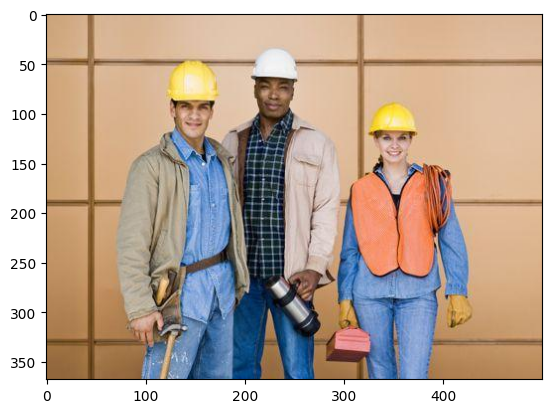

In [10]:
for i in range(1):
    # Read images
    path_to_image = IMAGES_PATH+images_list[i]
    img = keras.utils.load_img(path_to_image)
    # Convert int8 to float32
    img = tf.image.convert_image_dtype(img, tf.float32)

    # Append 1 extra dim as we are not using batches but the library expects them
    img = tf.expand_dims(img, 0)

    # Read files and extract annotations
    path_to_txt_file = LABELS_PATH+labels_list[i]
    with open(path_to_txt_file) as txt_file:
        labels = txt_file.readlines()

    # Extract classes as names
    image_classes = {classes[int(label[0])] for label in labels}
     # Extract bboxes
    bboxes = [label[2:-1].split(' ') for label in labels]
    bboxes = [float(element) for box in bboxes for element in box]
    bboxes = split_boxes(bboxes)

    formated_bboxes = []
    for bbox in bboxes:
        bbox = tf.convert_to_tensor(bbox)
        new_box = convert_format(bbox, 'xywh', 'xyxy')
        formated_bboxes.append(bbox)
    n_bboxes = len(formated_bboxes)
    formated_bboxes = tf.reshape(tf.convert_to_tensor(formated_bboxes), [1, n_bboxes, 4])

    drawn_plots = tf.image.draw_bounding_boxes(img, formated_bboxes, colors=np.array([[1.0, 0.0, 0.0]]))

#$keras.preprocessing.image.array_to_img(drawn_plots[0], 'channels_last')
plt.imshow(drawn_plots[0])

## Number of instances per class
